This notebook has the goal of testing MFA-models, and determining if it is a good model choice. 
The notebook aims to test:
-   Model Complexity - Will the model be able to get a good BIC score and out-of-sample likelyhood
-   Reconstruction Fidelity - Calculate the reconstruction error in RMSE and SAM (Spectral Angle Mapper)
-   Interpretability - Does the components represent different and new signals
-   Class Interpretability - Assign a colour to each FA, and map the Hyperspectral image next to its rgb-image, do we see the same structures?  

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from hypso import Hypso
from MFA import MFA # Your heteroscedastic MFA class
from utils import get_data
import glob
# Settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Loading the models, this includes the training statistics

In [4]:
data_product = 'l1b'
ADD_SPATIAL_INFO = False
K = 6
q = 2 

In [5]:
# Load PCA
if ADD_SPATIAL_INFO:
    spatial_str = "spatial"
else:
    spatial_str = "no_spatial"

# Load the L2 MFA Model
model_path = f'models/no_spatial/mfa_L2_k{K}_q{q}.pt' # <-- UPDATE THIS PATH
checkpoint = torch.load(model_path, map_location=device)

K_optimal = checkpoint['hyperparameters']['n_components']
q_optimal = checkpoint['hyperparameters']['n_factors']
D = checkpoint['hyperparameters']['n_features']

mfa_model = MFA(n_components=K_optimal, n_features=D, n_factors=q_optimal, device=device)
mfa_model.load_state_dict(checkpoint['model_state_dict'])
mfa_model.eval() # Set to evaluation mode
print(f"Loaded L2 MFA Model: K={K_optimal}, q={q_optimal}")

print("Models loaded successfully.")
print(f"MFA Config: K={K_optimal}, q={q_optimal}")

Loaded L2 MFA Model: K=6, q=2
Models loaded successfully.
MFA Config: K=6, q=2


Loading data, note that the models have differnet preprocessing steps

In [6]:
data_dir = glob.glob(f'data/testing_{data_product}/*.nc')
print(f"Found {len(data_dir)} files.")

target_total_samples = 10000

data_list = get_data(data_dir, data_product, target_total_samples, ADD_SPATIAL_INFO)

data = torch.from_numpy(data_list).float().to(device)

Found 8 files.
Aiming to extract ~1250 pixels per file from 8 files to reach a total of ~10000 samples.
0/8 | File: data/testing_l1b\gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc | Extracted 1250 pixels.
1/8 | File: data/testing_l1b\lacrau_2025-01-17T09-40-10Z-l1b.nc | Extracted 1250 pixels.
2/8 | File: data/testing_l1b\lakevolta_2023-01-19T09-40-06Z-l1b.nc | Extracted 1250 pixels.
3/8 | File: data/testing_l1b\mwanza_2022-07-21T07-43-03Z-l1b.nc | Extracted 1250 pixels.
4/8 | File: data/testing_l1b\princeWilliam_2022-12-09T19-57-47Z-l1b.nc | Extracted 1250 pixels.
5/8 | File: data/testing_l1b\svalbard_2022-07-31T11-43-59Z-l1b.nc | Extracted 1250 pixels.
6/8 | File: data/testing_l1b\uijsselmeer_2024-10-22T09-53-08Z-l1b.nc | Extracted 1250 pixels.
7/8 | File: data/testing_l1b\wildfirePerth_2025-03-17T01-54-12Z-l1b.nc | Extracted 1250 pixels.
------------------------------
Final Analysis Dataset Shape: (10000, 120)


### Reconstruction Logic

In [7]:
def reconstruct_mfa(model, X):
    """Reconstructs X using the Component-Specific posterior expectation."""
    with torch.no_grad():
        log_resp, _ = model.e_step(X) 
        responsibilities = torch.exp(log_resp) 
        cluster_ids = torch.argmax(responsibilities, dim=1)
        X_rec = torch.zeros_like(X)
        
        for k in range(model.K):
            mask = (cluster_ids == k)
            if mask.sum() == 0: continue
            
            X_k = X[mask]
            X_k_centered = X_k - model.mu[k]
            Lambda = model.Lambda[k] 
            
            psi_k = torch.exp(model.log_psi[k])
            Psi_inv = torch.diag(1.0 / psi_k) 
            
            M = torch.inverse(torch.eye(model.q, device=X.device) + Lambda.T @ Psi_inv @ Lambda)
            beta = M @ Lambda.T @ Psi_inv
            z_k = (X_k_centered @ beta.T)
            
            X_rec[mask] = z_k @ Lambda.T + model.mu[k]
            
    return X_rec, cluster_ids

with torch.no_grad():
    # 1. Flatten Data to 2D
    X_raw = torch.tensor(data, dtype=torch.float32, device=device)
    if X_raw.ndim == 3:
        X_raw = X_raw.reshape(-1, X_raw.shape[-1])
        
    # 2. Extract Physical Magnitude (Brightness)
    pixel_norms = torch.linalg.norm(X_raw, dim=1, keepdim=True).clamp(min=1e-8)
    
    # 3. L2 Normalize (The "Chemical Shape")
    X_normalized = X_raw / pixel_norms
    
    # --- PCA Benchmark (Trained dynamically on the L2 data for a fair fight) ---
    pca_mean = X_normalized.mean(dim=0)
    X_pca_input = X_normalized - pca_mean
    U, S, V = torch.pca_lowrank(X_pca_input, q=q_optimal) 
    pca_components = V
    
    z_pca = torch.matmul(X_pca_input, pca_components)
    X_rec_pca_shape = torch.matmul(z_pca, pca_components.T) + pca_mean
    
    # --- MFA Reconstruction ---
    X_rec_mfa_shape, cluster_ids = reconstruct_mfa(mfa_model, X_normalized)
    
    # --- RESTORE MAGNITUDE FOR PHYSICAL RMSE ---
    X_rec_pca_physical = X_rec_pca_shape * pixel_norms
    X_rec_mfa_physical = X_rec_mfa_shape * pixel_norms

    # Calculate Physical RMSE
    rmse_pca = torch.sqrt(torch.mean((X_raw - X_rec_pca_physical) ** 2))
    rmse_mfa = torch.sqrt(torch.mean((X_raw - X_rec_mfa_physical) ** 2))
    
    print("=== True Physical Reconstruction Benchmark ===")
    print(f"PCA (q={q_optimal}): RMSE = {rmse_pca.item():.4f}")
    print(f"MFA (K={mfa_model.K}, q={q_optimal}): RMSE = {rmse_mfa.item():.4f}")
    print("==============================================")

C:\Users\trygvemt\AppData\Local\Temp\ipykernel_22676\2076547948.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_raw = torch.tensor(data, dtype=torch.float32, device=device)


=== True Physical Reconstruction Benchmark ===
PCA (q=2): RMSE = 4.4445
MFA (K=6, q=2): RMSE = 3.1694


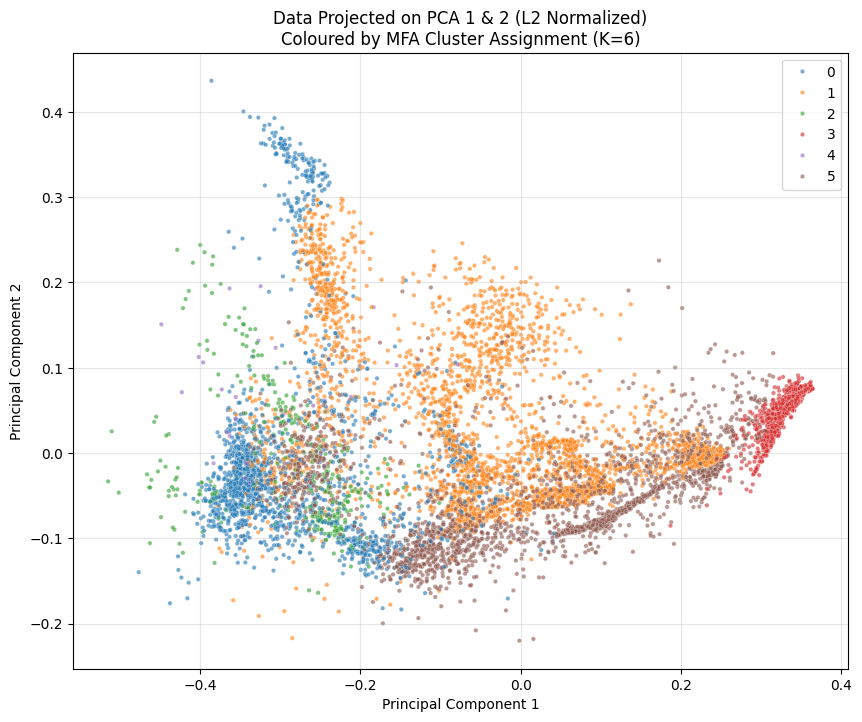

In [8]:
with torch.no_grad():
    # Ensure strictly 1D arrays for seaborn
    pc1 = z_pca[:, 0].cpu().numpy().flatten()
    pc2 = z_pca[:, 1].cpu().numpy().flatten()
    cluster_ids_plot = cluster_ids.cpu().numpy().flatten()

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=pc1, y=pc2, hue=cluster_ids_plot, 
        palette='tab10', s=10, alpha=0.6, legend='full'
    )
    
    plt.title(f"Data Projected on PCA 1 & 2 (L2 Normalized)\nColoured by MFA Cluster Assignment (K={mfa_model.K})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True, alpha=0.3)
    plt.show()

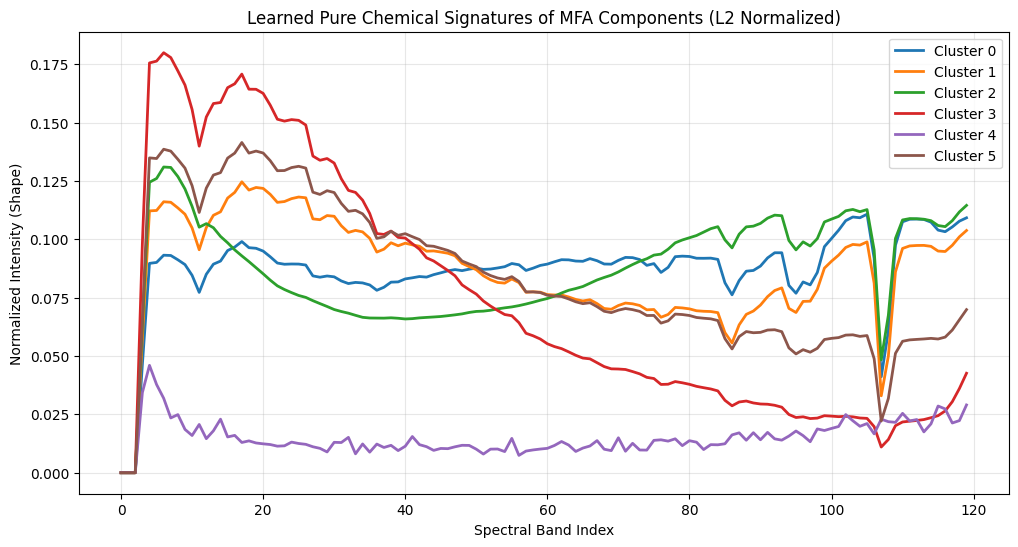

In [9]:
with torch.no_grad():
    # The learned means are now pure, normalized chemical shapes
    learned_means = mfa_model.mu.cpu().numpy()

plt.figure(figsize=(12, 6))

for k in range(mfa_model.K):
    plt.plot(learned_means[k], label=f'Cluster {k}', linewidth=2)

plt.title(f"Learned Pure Chemical Signatures of MFA Components (L2 Normalized)")
plt.xlabel("Spectral Band Index")
plt.ylabel("Normalized Intensity (Shape)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Class segmentation test

Image Shape: 956x684 with 120 bands


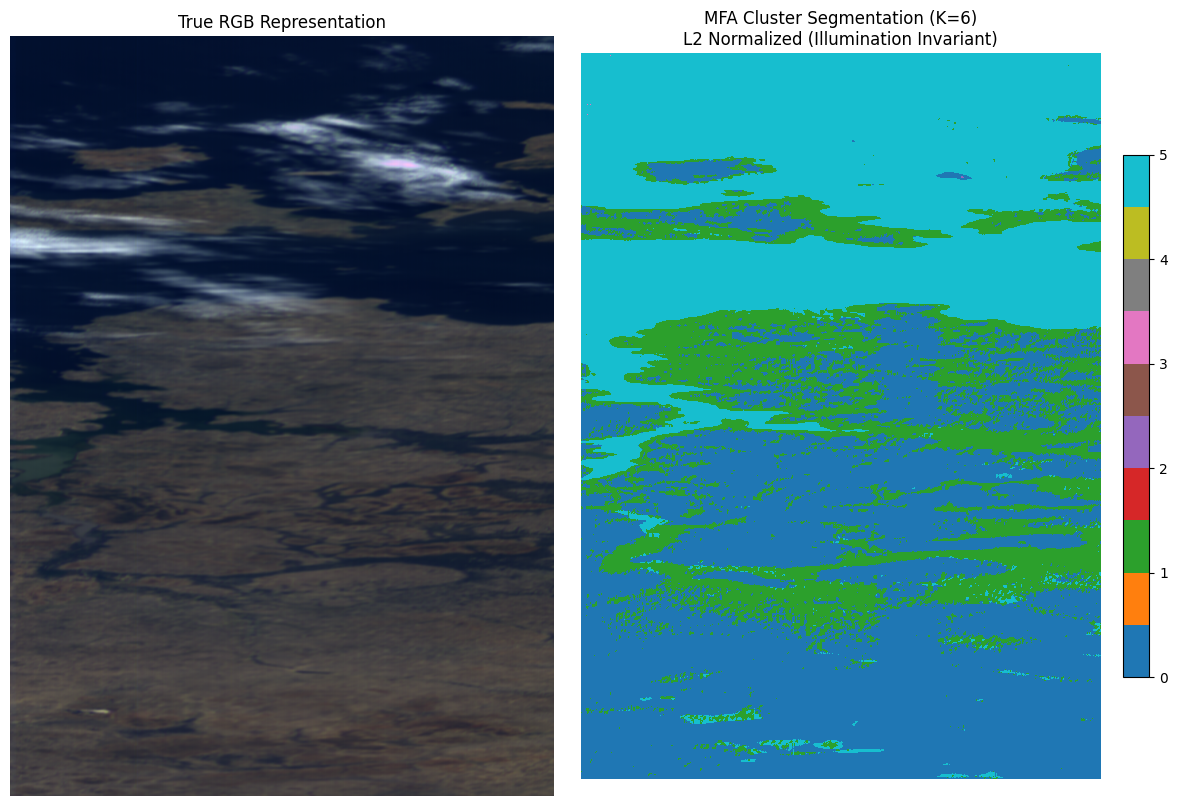

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from hypso import Hypso # Assuming this is already imported in your notebook

# Reshape clusters to image
file_testing = f'data/testing_{data_product}/mwanza_2022-07-21T07-43-03Z-l1{data_product[-1]}.nc'

satobj = Hypso(file_testing) 

# 1. Load the full image data
match data_product:
    case 'l1a':
        data = satobj.l1a_cube.values.astype(np.float32)
    case 'l1b':
        data = satobj.l1b_cube.values.astype(np.float32)
    case 'l1d':
        data = satobj.l1d_cube.values.astype(np.float32)
    case _:
        raise ValueError(f"Unknown data product: {data_product}")

h, w, b = data.shape
print(f"Image Shape: {h}x{w} with {b} bands")

# Flatten the full image for the model
data_2d_full = data.reshape(-1, b) # Shape: (Total_Pixels_In_Image, 120)

# =====================================================================
# 2. Preprocess the full image (THE NEW L2 NORMALIZATION)
# =====================================================================
data_2d_full_tensor = torch.tensor(data_2d_full, dtype=torch.float32).to(device)

# We project every single pixel onto the unit hypersphere independently.
# This mathematically deletes shadows and sunlight from the image!
X_full_mfa = F.normalize(data_2d_full_tensor, p=2, dim=1)

# =====================================================================
# 3. Run Inference to get NEW cluster_ids for this specific image
# =====================================================================
with torch.no_grad():
    # We only need the responsibilities to get the argmax (cluster id)
    log_resp, _ = mfa_model.e_step(X_full_mfa)
    responsibilities = torch.exp(log_resp)
    new_cluster_ids = torch.argmax(responsibilities, dim=1)

# 4. NOW reshape the new IDs back into the 2D image grid
seg_map = new_cluster_ids.reshape(h, w).cpu().numpy()

# Get RGB for comparison (Bands 70, 50, 20 approx for Hypso)
rgb_bands = [70, 50, 20]
rgb_img = data[:, :, rgb_bands]
# Normalize RGB for display
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

# =====================================================================
# Plotting
# =====================================================================
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# 1. Plot True RGB
# aspect='equal' ensures 1 pixel is square (fixes the squashing)
ax[0].imshow(rgb_img, aspect='equal') 
ax[0].set_title("True RGB Representation")
ax[0].axis('off')

# 2. Plot Segmentation Map using imshow instead of heatmap
# cmap='tab10': Good distinct colors for categorical data
# interpolation='nearest': Keeps edges sharp (no blurring between classes)
# aspect='equal': Matches the geometry of the RGB image exactly
im = ax[1].imshow(seg_map, cmap='tab10', interpolation='nearest', aspect='equal')
ax[1].set_title(f"MFA Cluster Segmentation (K={mfa_model.K})\nL2 Normalized (Illumination Invariant)")
ax[1].axis('off')

# Optional: Add a legend for the clusters
# This creates a colorbar with discrete ticks for each cluster
cbar = plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_ticks(np.arange(mfa_model.K)) # Align ticks with the actual integer class labels
cbar.set_ticklabels(np.arange(mfa_model.K))  # Label as 0, 1, 2...

plt.tight_layout()
plt.show()

### Spectral Components

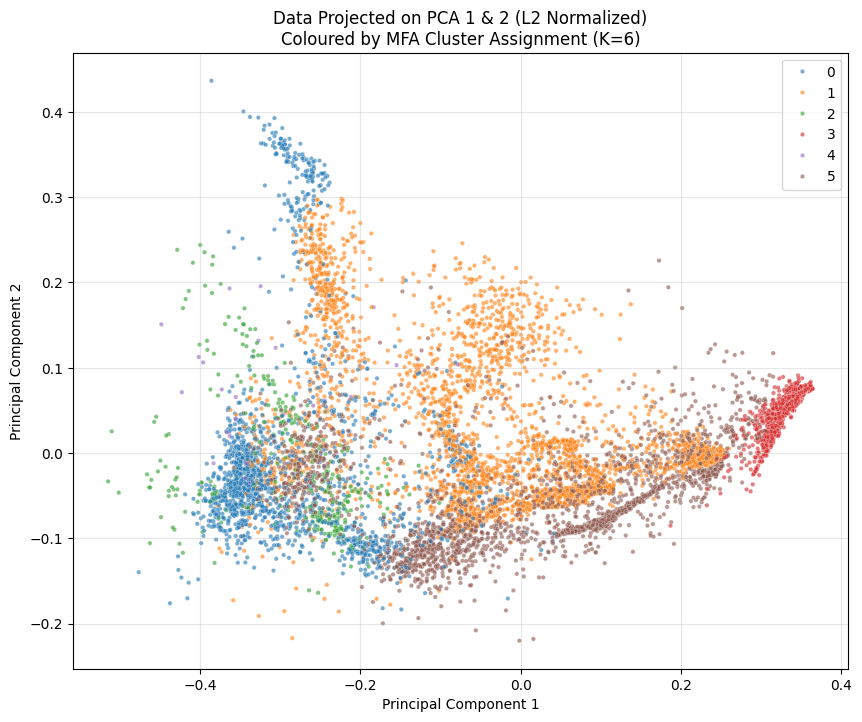

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

with torch.no_grad():
    # Flatten just in case
    z_pca = z_pca.view(-1, z_pca.shape[-1])
    
    # Extract PCs and flatten for seaborn
    pc1 = z_pca[:, 0].cpu().numpy().flatten()
    pc2 = z_pca[:, 1].cpu().numpy().flatten()

    # Get MFA assignments on the normalized data
    log_resp, _ = mfa_model.e_step(X_normalized)
    responsibilities = torch.exp(log_resp)
    
    # Extract IDs and flatten for seaborn
    cluster_ids_plot = torch.argmax(responsibilities, dim=1).cpu().numpy().flatten()

    plt.figure(figsize=(10, 8))
    
    sns.scatterplot(
        x=pc1, 
        y=pc2, 
        hue=cluster_ids_plot, 
        palette='tab10', 
        s=10,             
        alpha=0.6,        
        legend='full'
    )
    
    plt.title(f"Data Projected on PCA 1 & 2 (L2 Normalized)\nColoured by MFA Cluster Assignment (K={mfa_model.K})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True, alpha=0.3)
    plt.show()

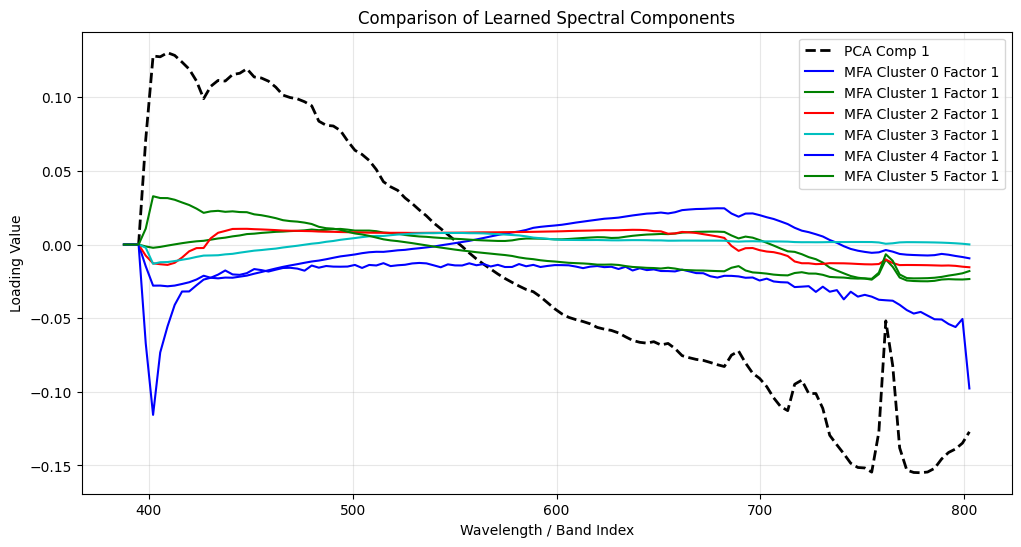

In [12]:
wavelengths = satobj.wavelengths if hasattr(satobj, 'wavelengths') else np.arange(120)

plt.figure(figsize=(12, 6))

# Plot PCA First Component
plt.plot(wavelengths, pca_components[:, 0].cpu().numpy(), 'k--', label='PCA Comp 1', linewidth=2)

# Plot MFA Component 1 for each cluster
colors = ['b', 'g', 'r', 'c']
for k in range(mfa_model.K):
    # Extract Factor Loading Matrix (Lambda) for cluster k
    # Shape (D, q), we take first factor
    loading = mfa_model.Lambda[k][:, 0].detach().cpu().numpy()
    plt.plot(wavelengths, loading, label=f'MFA Cluster {k} Factor 1', color=colors[k % len(colors)])

plt.xlabel("Wavelength / Band Index")
plt.ylabel("Loading Value")
plt.title("Comparison of Learned Spectral Components")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Scatterplot of the points assigned to MFA cluster 0 and MFA cluster 1

In [13]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we are in no_grad mode for inference
with torch.no_grad():
    
    # --- Convert NumPy array to PyTorch Tensor ---
    data_tensor = torch.tensor(data, dtype=torch.float32, device=pca_mean.device)

    # --- THE FIX: Flatten the 3D Image Cube into a 2D Pixel List ---
    # If the image is (Height, Width, Bands), reshape to (Height * Width, Bands)
    if data_tensor.ndim == 3:
        data_tensor = data_tensor.reshape(-1, data_tensor.shape[-1])

    # Use data_tensor instead of data
    X_for_pca = data_tensor - pca_mean
    
    # Preprocess for MFA
    X_for_mfa = (data_tensor / mfa_stats['data_max']) - mfa_stats['mean']

    # A) Project onto PCA components (Global View)
    z_pca = torch.matmul(X_for_pca, pca_components)
    
    # Ensure strictly 1D arrays
    pc1 = z_pca[:, 0].cpu().numpy().flatten()
    pc2 = z_pca[:, 1].cpu().numpy().flatten()

    # B) Get MFA Cluster Assignments (Local View)
    log_resp, _ = mfa_model.e_step(X_for_mfa)
    responsibilities = torch.exp(log_resp)
    
    # Assign each pixel to the cluster with the highest responsibility
    cluster_ids = torch.argmax(responsibilities, dim=1).cpu().numpy().flatten()

    # --- Plotting ---
    plt.figure(figsize=(10, 8))
    plt.axis('equal') 

    # Use seaborn for easy coloring by category
    sns.scatterplot(
        x=pc1, 
        y=pc2, 
        hue=cluster_ids, 
        palette='tab10',  # Distinct colors for clusters
        s=10,             # Marker size
        alpha=0.6,        # Transparency to see density
        legend='full'
    )
    
    plt.title(f"Data Projected on PCA 1 & 2\nColoured by MFA Cluster Assignment (K={mfa_model.K})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True, alpha=0.3)
    plt.show()

NameError: name 'mfa_stats' is not defined

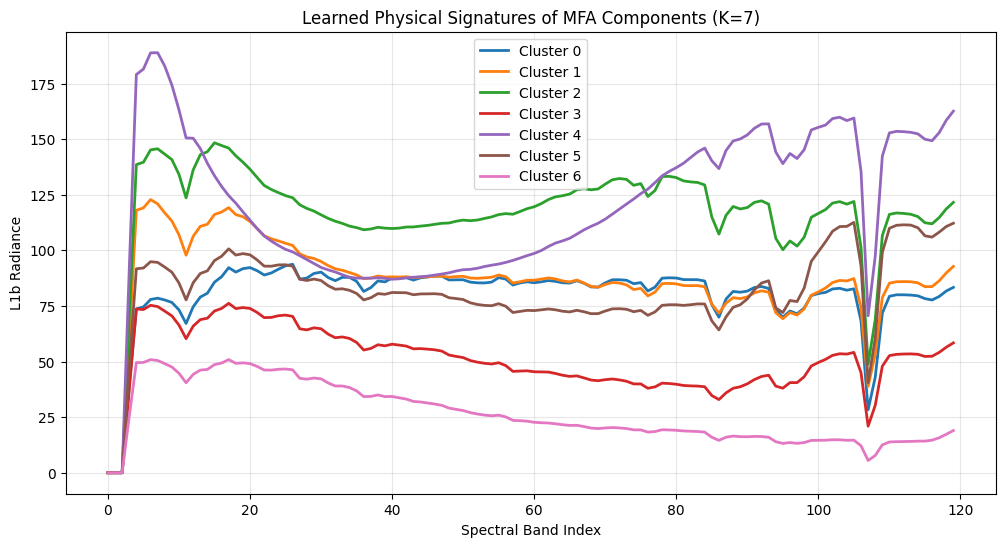

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    # Extract the learned means (endmembers)
    # Shape: (K, 120)
    learned_means = mfa_model.mu.cpu().numpy()
    
    # De-process them back to physical scale so they look like real L1b data
    physical_means = (learned_means + mfa_stats['mean'].cpu().numpy()) * mfa_stats['data_max'].cpu().numpy()

plt.figure(figsize=(12, 6))

# Plot each cluster's mean spectral signature
for k in range(mfa_model.K):
    plt.plot(physical_means[k], label=f'Cluster {k}', linewidth=2)

plt.title(f"Learned Physical Signatures of MFA Components (K={mfa_model.K})")
plt.xlabel("Spectral Band Index")
plt.ylabel("L1b Radiance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Register 3D projection
import numpy as np

# Ensure we are in no_grad mode
with torch.no_grad():

    # Preprocess for PCA (Center the data)
    X_for_pca = data - pca_mean
    
    # Preprocess for MFA (Scale and Center using MFA stats)
    X_for_mfa = (data / mfa_stats['data_max']) - mfa_stats['mean']

    # Check if we have enough components
    if pca_components.shape[1] < 3:
        print(f"Warning: PCA matrix only has {pca_components.shape[1]} components. Cannot plot 3D.")
    else:
        # Project to latent space (N, n_components)
        z_pca = torch.matmul(X_for_pca, pca_components)
        
        # Extract first 3 Principal Components
        pc1 = z_pca[:, 0].cpu().numpy()
        pc2 = z_pca[:, 1].cpu().numpy()
        pc3 = z_pca[:, 2].cpu().numpy()

        # B) Get MFA Cluster Assignments
        # e_step returns log probabilities; exp() gives us responsibilities (gamma)
        log_resp, _ = mfa_model.e_step(X_for_mfa)
        responsibilities = torch.exp(log_resp)
        
        # Assign pixel to the cluster with the highest responsibility
        cluster_ids = torch.argmax(responsibilities, dim=1).cpu().numpy()


        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Create the scatter plot
        scatter = ax.scatter(
            pc1, pc2, pc3,
            c=cluster_ids,       # Color by MFA cluster
            cmap='tab10',        # Discrete color map
            s=5,                 # Small marker size for density
            alpha=0.6,            # Transparency
        )
        
        # Add a legend
        legend = ax.legend(*scatter.legend_elements(), title="MFA Clusters")
        ax.add_artist(legend)

        # Labels and Title
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.set_title(f"3D PCA Projection\nColored by MFA Cluster Assignment (K={mfa_model.K})")
        
        # Optional: Adjust initial view angle (elevation, azimuth)
        ax.view_init(elev=20, azim=45)
        
        plt.tight_layout()
        plt.show()

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'